# Импорт библиотек

In [989]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import optuna
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso

# Функции и классы

In [990]:
def get_visual_residual_analysis(y_pred, y_true):
    
    """
    Создает визуализацию анализа остатков, включая сравнение предсказанных и реальных значений,
    а также распределение остатков.

    Параметры:
    y_pred: массив
        Предсказанные значения зависимой переменной моделью.
    y_true: массив
        Фактические значения зависимой переменной.
    """

    # Расчет остатков
    resid = y_true - y_pred

    # Создание фигуры и набора подграфиков
    fig, ax = plt.subplots(2, 2, figsize=(9, 8))

    # Подграфик 1: Диаграмма рассеивания предсказанных значений и фактических значений
    sns.scatterplot(x=y_true, y=y_pred, ax=ax[0][0])
    # Линия идентичности (x=y)
    ax[0][0].plot(ax[0][0].get_xlim(), ax[0][0].get_xlim(), color='r', linestyle='--')
    # Форматирование подграфика
    ax[0][0].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
    ax[0][0].set_title('Предсказания и реальные значения')
    ax[0][0].set_xlabel('Реальные значения')
    ax[0][0].set_ylabel('Предсказанные значения')

    # Подграфик 2: Диаграмма рассеивания предсказанных значений и остатков
    sns.scatterplot(x=y_pred, y=resid, ax=ax[0][1])
    # Горизонтальная линия на уровне y=0
    ax[0][1].axhline(0, linestyle='--', color='r')
    # Форматирование подграфика
    ax[0][1].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
    ax[0][1].set_title('Остатки и предсказанные значения')
    ax[0][1].set_xlabel('Предсказанные значения')
    ax[0][1].set_ylabel('Остатки регрессии')

    # Подграфик 3: Гистограмма и кривая плотности остатков
    sns.histplot(resid, stat='density', color='Azure', ax=ax[1][0])
    # Добавление кривой плотности
    sns.kdeplot(resid, color='RoyalBlue', ax=ax[1][0], label='Оценка плотности')
    # Нормальное распределение для сравнения
    x = np.linspace(ax[1][0].get_xlim()[0], ax[1][0].get_xlim()[1], 100)
    p = stats.norm.pdf(x, 0, np.std(resid))
    ax[1][0].plot(x, p, color='r', linestyle='--', label='Нормальное р-е')
    # Форматирование подграфика
    ax[1][0].set_title('Гистограмма остатков')
    ax[1][0].legend(fontsize=8, frameon=False)
    ax[1][0].set_xlabel('Остатки регрессии')
    ax[1][0].set_ylabel('Плотность')

    # Подграфик 4: Q-Q plot для остатков
    pg.qqplot(resid, color='RoyalBlue', ax=ax[1][1])
    # Форматирование подграфика
    ax[1][1].set_title('Q-Q Plot') 
    ax[1][1].set_xlabel('Теоретические квантили')
    ax[1][1].set_ylabel('Наблюдаемые квантили')

    plt.tight_layout()


def get_residual_analysis(resid, exog, alpha):

    """
    Выполняет статистические тесты для анализа остатков регрессии, включая проверку на нормальность,
    гомоскедастичность и гетероскедастичность.

    Параметры:
    resid: массив
        Остатки регрессионной модели.
    exog: массив
        Экзогенные переменные, использованные в модели.
    alpha: float
        Уровень значимости для тестов.
    """

    # Статистические тесты 
    p_shapiro = stats.shapiro(resid)[1]
    p_breuschpagan = sm.stats.het_breuschpagan(resid, exog)[1]
    p_white = sm.stats.het_white(resid, exog)[1]

    # Проверка значимости p-значений
    result_shapiro = p_shapiro < alpha
    result_breuschpagan = p_breuschpagan < alpha
    result_white = p_white < alpha

    # Выводы по результатам тестов
    if result_shapiro == True:
        conclusion_shapiro = 'Остатки не распределены нормально'
    else:
        conclusion_shapiro = 'Недостаточно оснований для отклонения гипотезы о нормальности остатков'
    
    if result_breuschpagan == True:
        conclusion_breuschpagan = 'Присутствует гетероскедастичность'
    else:
        conclusion_breuschpagan = 'Недостаточно оснований для отклонения гипотезы о гомоскедастичности остатков'
    
    if result_white == True:
        conclusion_white = 'Присутствует гетероскедастичность'
    else:
        conclusion_white = 'Недостаточно оснований для отклонения гипотезы о гомоскедастичности остатков'

    # Таблица результатов
    result = pd.DataFrame(
        {
            'p-values': [p_shapiro, p_breuschpagan, p_white],
            'Отклоняем H0': [result_shapiro, result_breuschpagan, result_white],
            'Вывод': [conclusion_shapiro, conclusion_breuschpagan, conclusion_white]
        },
        index=['Тест Шапиро-Уилка', 'Тест Бреуша-Пагана', 'Тест Уайта']
    )

    return result

    
def calculate_metrics(y_true_train, y_pred_train, y_true_test, y_pred_test):
    metrics_train = [
        r2_score(y_true=y_true_train, y_pred=y_pred_train),
        mean_absolute_error(y_true=y_true_train, y_pred=y_pred_train),
        mean_absolute_percentage_error(y_true=y_true_train, y_pred=y_pred_train)
    ]
    metrics_test = [
        r2_score(y_true=y_true_test, y_pred=y_pred_test),
        mean_absolute_error(y_true=y_true_test, y_pred=y_pred_test),
        mean_absolute_percentage_error(y_true=y_true_test, y_pred=y_pred_test)
    ]
    return metrics_train + metrics_test


class Vifs: 

    """
    Класс для расчета факторов инфляции дисперсии (VIF) для набора переменных и их визуализации.
    """

    def __init__(self):

        """
        Инициализирует экземпляр класса Vifs.
        """

        self.X = None
        self.vifs = None
        self.X_without_vifs = None
        self.vifs_X_without_vifs = None

    def calculate_vifs(self, X: pd.DataFrame):

        """
        Рассчитывает VIF для каждого признака в предоставленном DataFrame и последовательно исключает признаки
        с VIF больше 10.

        Параметры:
        X: DataFrame
            Датафрейм с набором признаков для расчета VIF.
        """

        self.X = X
        vifs = pd.Series(
            [variance_inflation_factor(self.X.values, i) for i in range(self.X.shape[1])],
            index=self.X.columns
        ).sort_values()
        # Расчет VIF для каждого признака в датафрейме
        self.vifs = vifs

        X_without_vifs = X.copy()
        vifs_X_without_vifs = vifs.copy()
        
        # Цикл для исключения признаков с VIF > 10
        while True:

            if vifs_X_without_vifs.max() <= 10:
                break  # Прекращение цикла, если все VIF <= 10

            # Обновление датафрейма, исключая признак с максимальным VIF
            X_without_vifs = X[vifs_X_without_vifs[vifs_X_without_vifs != vifs_X_without_vifs.max()].index]
            # Расчет новых VIF после исключения признака
            vifs_X_without_vifs = pd.Series(
                [variance_inflation_factor(X_without_vifs.values, i) for i in range(X_without_vifs.shape[1])],
                index=X_without_vifs.columns
            ).sort_values()

        self.X_without_vifs = X_without_vifs
        self.vifs_X_without_vifs = vifs_X_without_vifs

    def get_visual(self):

        """
        Создать визуализацию VIFs до и после удаления высоких значений с помощью seaborn barplot.
        """
        
        fig, axes = plt.subplots(2, figsize=(12, 10))
        sns.barplot(
            x=self.vifs.index, 
            y=self.vifs, 
            palette="viridis",
            ax=axes[0]
        )
        axes[0].bar_label(axes[0].containers[0], fontsize=10, fmt='%.2f')
        axes[0].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
        axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=20, ha="right")
        axes[0].set_title('VIF до удаления переменных')
        axes[0].set_ylabel('VIF')
        axes[0].axhline(10, linestyle='--', c='coral')

        sns.barplot(
            x=self.vifs_X_without_vifs.index, 
            y=self.vifs_X_without_vifs, 
            palette="viridis",
            ax=axes[1]
        )
        axes[1].bar_label(axes[1].containers[0], fontsize=10, fmt='%.2f')
        axes[1].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)
        axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=20, ha="right")
        axes[1].set_title('Пересчитанные VIF после удаления переменных')
        axes[1].set_ylabel('VIF')
        axes[1].axhline(10, linestyle='--', c='coral')
        plt.tight_layout()

# Импорт данных

In [991]:
data = pd.read_csv('Life-Expectancy-Data-Updated.csv').reset_index(drop=True)
data.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


In [992]:
data.to_excel('data_head.xlsx', index=False)

# Информация о переменных

- `Country`: Категориальный признак, обозначающий страну.
- `Region`: Категориальный признак, обозначающий регион.
- `Year`: Год, когда были собраны данные.
- `Infant_deaths`: Количество смертей среди младенцев.
- `Under_five_deaths`: Количество смертей детей младше пяти лет.
- `Adult_mortality`: Уровень смертности среди взрослого населения.
- `Alcohol_consumption`: Уровень потребления алкоголя на душу населения.
- `Hepatitis_B`: Процент населения, вакцинированного против гепатита В.
- `Measles`: Количество случаев заболевания корью.
- `BMI`: Средний индекс массы тела населения.
- `Polio`: Процент населения, вакцинированного против полиомиелита.
- `Total_expenditure`: Общие расходы на здравоохранение как процент от ВВП.
- `Diphtheria`: Процент населения, вакцинированного против дифтерии.
- `Incidents_HIV`: Количество новых случаев ВИЧ на 1000 неинфицированных населения.
- `GDP_per_capita`: ВВП на душу населения.
- `Population_mln`: Население страны в миллионах.
- `Thinness_ten_nineteen_years`: Процент детей и подростков от 10 до 19 лет, испытывающих дефицит веса.
- `Thinness_five_nine_years`: Процент детей от 5 до 9 лет, испытывающих дефицит веса.
- `Schooling`: Среднее количество лет обучения населения.
- `Economy_status_Developed`: Дамми-переменная, указывающая на развитый статус экономики.
- `Economy_status_Developing`: Дамми-переменная, указывающая на развивающийся статус экономики.
- `Life_expectancy`: Средняя ожидаемая продолжительность жизни населения.


In [993]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      2864 non-null   object 
 1   Region                       2864 non-null   object 
 2   Year                         2864 non-null   int64  
 3   Infant_deaths                2864 non-null   float64
 4   Under_five_deaths            2864 non-null   float64
 5   Adult_mortality              2864 non-null   float64
 6   Alcohol_consumption          2864 non-null   float64
 7   Hepatitis_B                  2864 non-null   int64  
 8   Measles                      2864 non-null   int64  
 9   BMI                          2864 non-null   float64
 10  Polio                        2864 non-null   int64  
 11  Diphtheria                   2864 non-null   int64  
 12  Incidents_HIV                2864 non-null   float64
 13  GDP_per_capita    

# Промежуточные действия

Цель исследования заключается в разработке предиктивной модели, которая позволит оценить среднюю ожидаемую продолжительность жизни населения. В рамках данного анализа особое внимание будет уделено исключению из рассмотрения тех переменных, которые имеют прямую корреляцию с показателями смертности. Это решение обусловлено стремлением исключить непосредственное влияние факторов смертности на прогностическую способность модели и сосредоточиться на обнаружении других, менее очевидных детерминант продолжительности жизни.

In [994]:
data = data.drop(['Economy_status_Developing', 'Infant_deaths', 'Under_five_deaths', 'Adult_mortality'], axis=1)

# Перезапишу, чтобы переменная автоматически определилась как категориальная
data.Economy_status_Developed = data.Economy_status_Developed.map({
    1: 'Developed',
    0: 'Developing'
})

В ходе предварительной обработки данных переменная "Economy_status_Developing", которая представлена в виде двоичного признака, была исключена из набора предикторов. Это решение было обосновано наличием комплементарной переменной "Economy_status_Developed". Учитывая, что данные переменные образуют полный набор взаимоисключающих категорий, наличие одной из них достаточно для сохранения целостности информации о статусе экономики страны. Таким образом, отсутствие значения в переменной "Economy_status_Developed" (то есть, его равенство нулю) непосредственно указывает на то, что экономика страны является развивающейся.

In [995]:
cat_vars = data.select_dtypes(object).columns
num_vars = data.select_dtypes([int, float]).columns

# Удаление пропущенных значений

In [996]:
data = data.dropna()

# Описательные статистики

### Для числовых признаков:

In [997]:
data.describe()

,Year,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Life_expectancy
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,2007.500000,4.820882,84.292598,77.344972,25.032926,86.499651,86.271648,0.894288,11540.924930,36.675915,4.865852,4.899825,7.632123,68.856075
std,4.610577,3.981949,15.995511,18.659693,2.193905,15.080365,15.534225,2.381389,16934.788931,136.485867,4.438234,4.525217,3.171556,9.405608
min,2000.000000,0.000000,12.000000,10.000000,19.800000,8.000000,16.000000,0.010000,148.000000,0.080000,0.100000,0.100000,1.100000,39.400000
25%,2003.750000,1.200000,78.000000,64.000000,23.200000,81.000000,81.000000,0.080000,1415.750000,2.097500,1.600000,1.600000,5.100000,62.700000
50%,2007.500000,4.020000,89.000000,83.000000,25.500000,93.000000,93.000000,0.150000,4217.000000,7.850000,3.300000,3.400000,7.800000,71.400000
75%,2011.250000,7.777500,96.000000,93.000000,26.400000,97.000000,97.000000,0.460000,12557.000000,23.687500,7.200000,7.300000,10.300000,75.400000
max,2015.000000,17.870000,99.000000,99.000000,32.100000,99.000000,99.000000,21.680000,112418.000000,1379.860000,27.700000,28.600000,14.100000,83.800000


### Для категориальных признаков:

In [998]:
data.describe(include=[object])

,Country,Region,Economy_status_Developed
count,2864,2864,2864
unique,179,9,2
top,Turkiye,Africa,Developing
freq,16,816,2272


# Кодирование категориальных признаков

In [999]:
for i in cat_vars:
    data[i] = LabelEncoder().fit_transform(data[i])

data.head()

,Country,Region,Year,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Life_expectancy
0,164,4,2015,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,1,76.5
1,148,3,2015,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,0,82.8
2,74,1,2007,1.57,60,35,21.2,67,64,0.13,1076,1183.21,27.1,28.0,5.0,1,65.4
3,69,8,2006,5.68,93,74,25.3,92,93,0.79,4146,0.75,5.7,5.5,7.9,1,67.0
4,79,4,2012,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,0,81.7


# Делю датасет на объясняющие и целевую переменную

In [1000]:
y_name = 'Life_expectancy'
X, y = data.drop(y_name, axis=1), data[y_name]

num_vars = set(num_vars)
num_vars.remove('Life_expectancy')

# Разделю на тренировочную и тестовую часть

In [1001]:
# Сначала разделим только целевые переменные, чтобы получить индексы
y_train, y_test = train_test_split(
    y, test_size=0.2, random_state=42
)

# Теперь используем индексы целевой переменной для разделения признаков
X_train = X.loc[y_train.index]
X_test = X.loc[y_test.index]

# Масштабирование посредством стандартизации

In [1002]:
scaler = StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train.head()

,Country,Region,Year,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed
2026,1.177860,-0.651486,1.380443,-0.597552,0.911076,1.174570,-0.965776,0.822440,0.812860,-0.378718,-0.469740,-0.117407,2.359220,2.261556,1.016169,0.510754
651,-0.877876,0.099863,-0.768351,2.152524,0.849564,1.120365,0.714594,0.624325,0.748902,-0.349362,0.132096,-0.194487,-0.622213,-0.595807,1.235473,-1.957890
2225,1.667320,1.978235,1.380443,0.442814,-0.380669,0.307277,0.714594,-0.498330,-0.530256,-0.215165,0.247290,-0.049945,-0.736008,-0.752069,0.734206,0.510754
2357,-1.719749,1.602561,0.520925,0.011626,0.911076,1.120365,0.487517,0.822440,0.812860,-0.370331,-0.476527,-0.247597,-0.781526,-0.752069,0.514901,0.510754
670,0.473036,-1.027160,-0.983230,-0.637662,-0.073111,-0.722634,-0.829530,-0.300214,-0.466298,3.701711,-0.492710,-0.255101,2.131630,2.105294,-0.581621,0.510754


#  Удаление выбросов

In [1003]:
X_train = X_train[np.abs(X_train) < 3].dropna()
y_train = y_train[X_train.index]

# Корреляционный анализ

### Корреляции признаков между собой:

<Axes: >

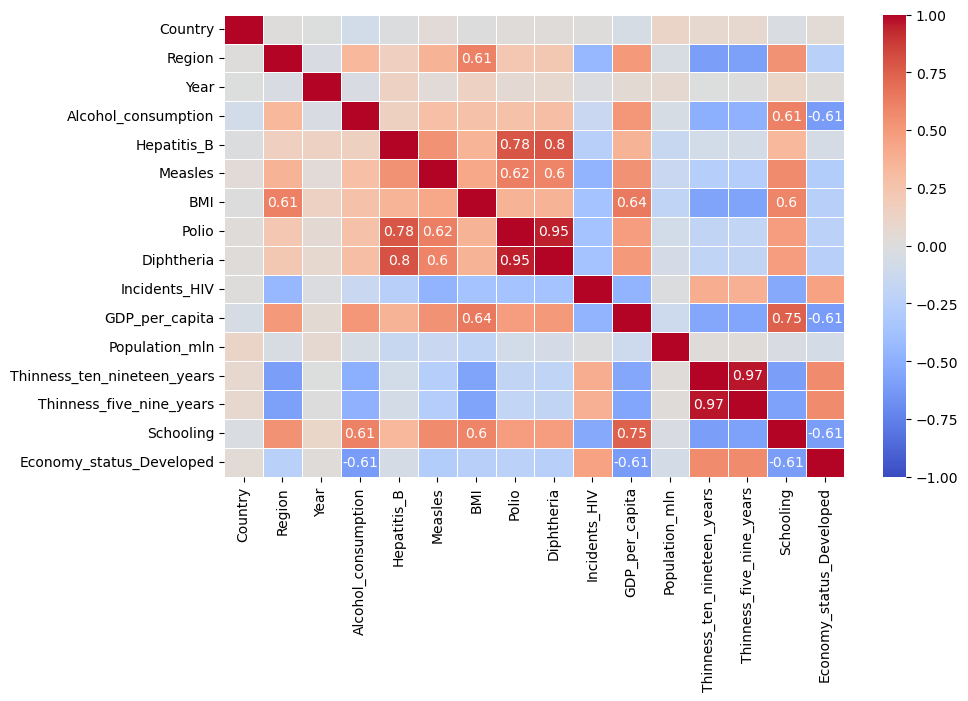

In [1004]:
corr_matrix = X_train.corr(method='spearman')

annot = corr_matrix.round(2)[(np.abs(corr_matrix) > 0.6) & (np.abs(corr_matrix) < 1)].fillna('')

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, linewidths=0.5,
    annot=annot,
    cmap="coolwarm",
    fmt=''
)

### Корреляции целевой переменной с объясняющими:

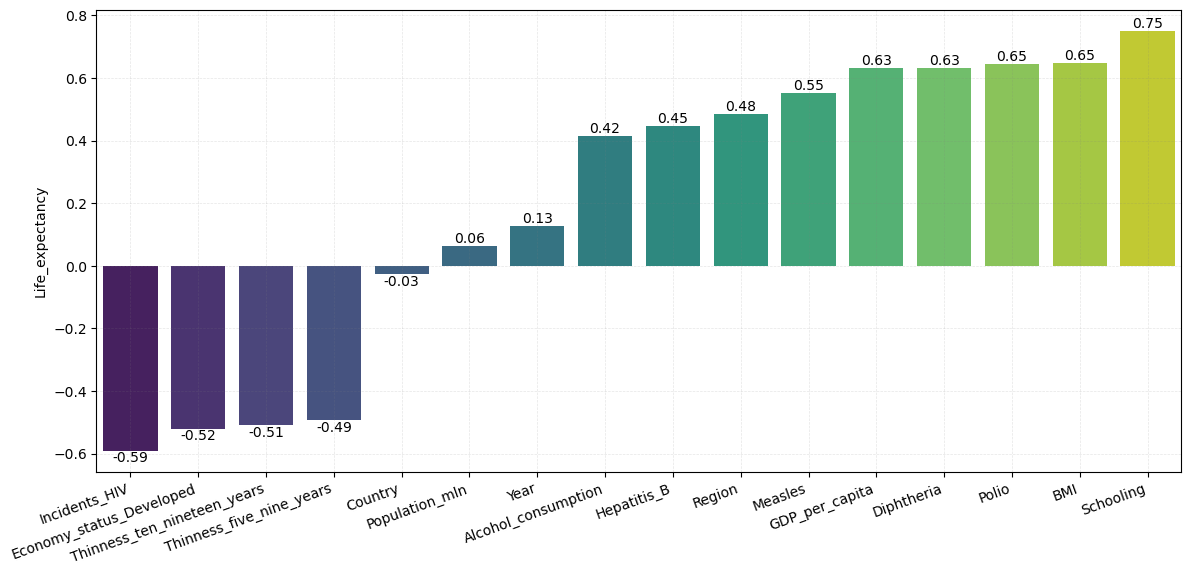

In [1005]:
y_corr = pd.concat([X_train, y_train], axis=1).corr()[y_name].drop(y_name).sort_values()

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=y_corr.index, 
    y=y_corr, 
    palette="viridis",

)
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)

# Анализ мультиколлинеарности

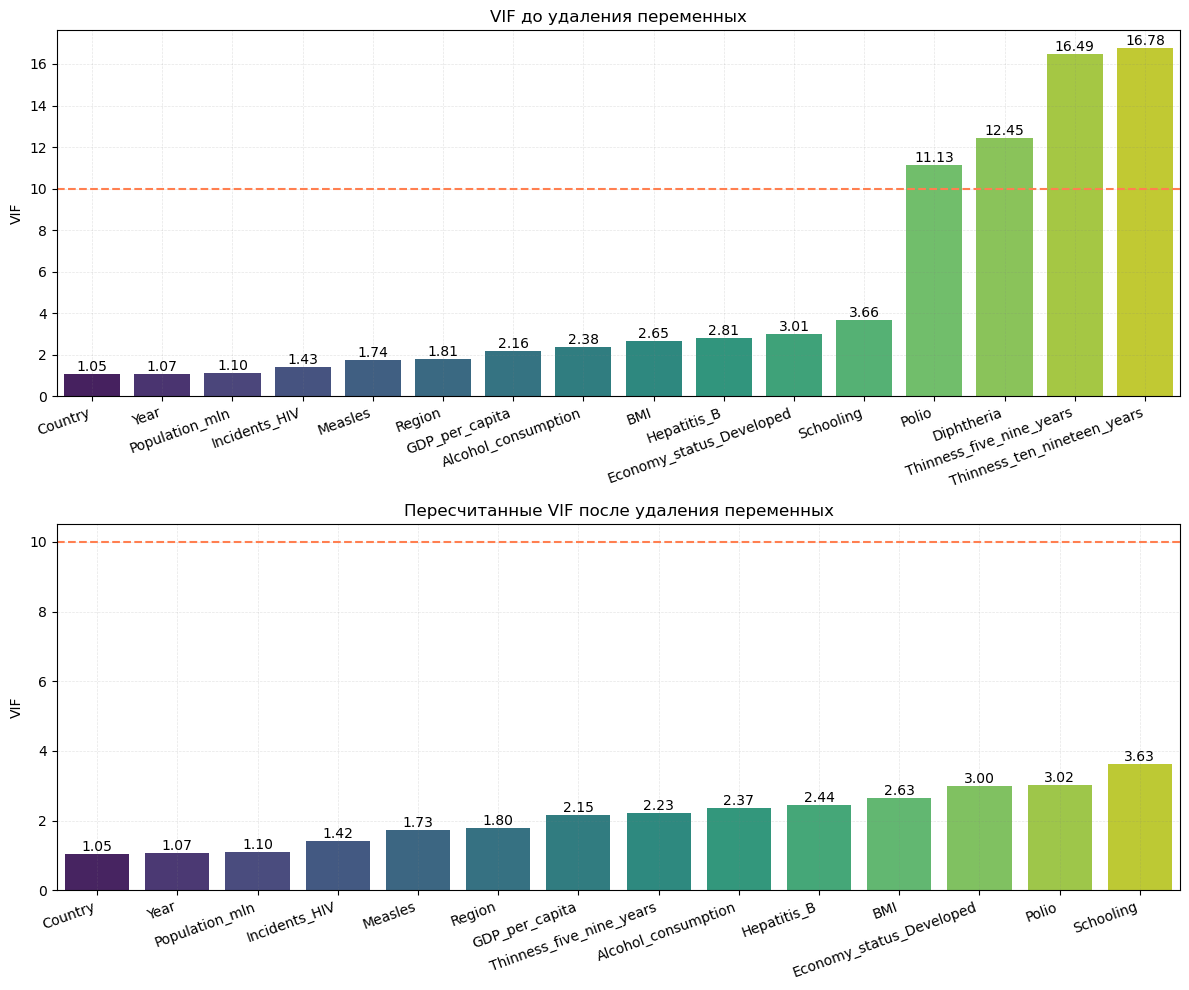

In [1006]:
vifs = Vifs()
vifs.calculate_vifs(X_train)

X_train_without_vifs = vifs.X_without_vifs
X_test_without_vifs = X_test[X_train_without_vifs.columns]

vifs.get_visual()

# Классическая модель линейной регрессии

In [1007]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     563.7
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:51:53   Log-Likelihood:                -5447.2
No. Observations:                2006   AIC:                         1.093e+04
Df Residuals:                    1989   BIC:                         1.102e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

### Анализ остатков

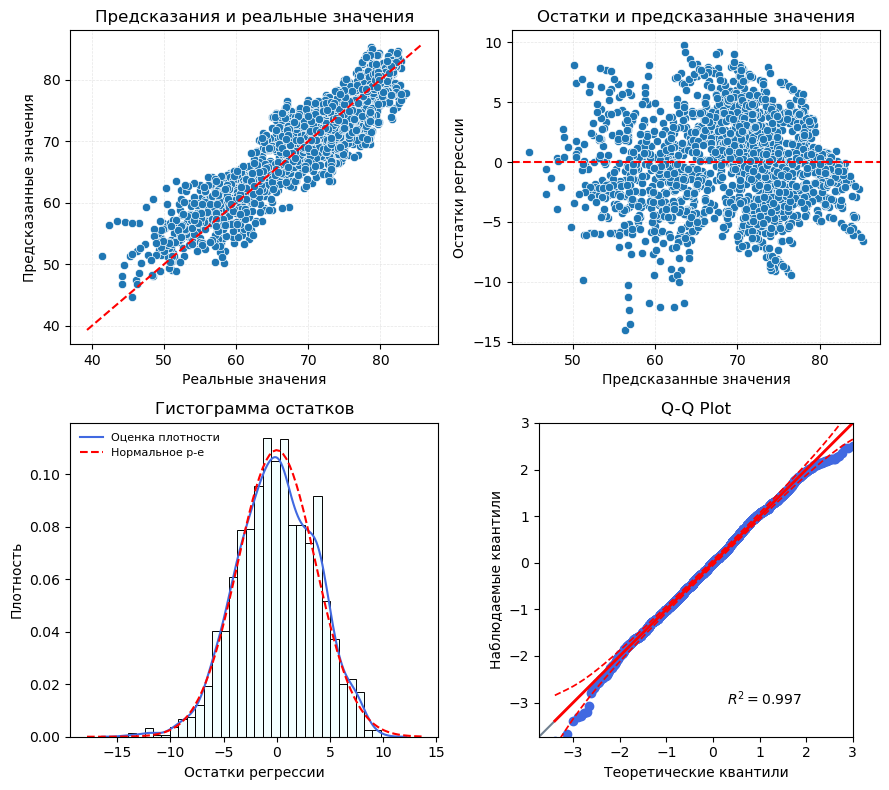

In [1008]:
get_visual_residual_analysis(model.fittedvalues, model.model.endog)

In [1009]:
get_residual_analysis(model.resid, model.model.exog, 0.05) 

,p-values,Отклоняем H0,Вывод
Тест Шапиро-Уилка,1.594032e-04,True,Остатки не распределены нормально
Тест Бреуша-Пагана,1.383681e-23,True,Присутствует гетероскедастичность
Тест Уайта,1.703274e-71,True,Присутствует гетероскедастичность


*Анализ гетероскедастичности для каждого признака:*

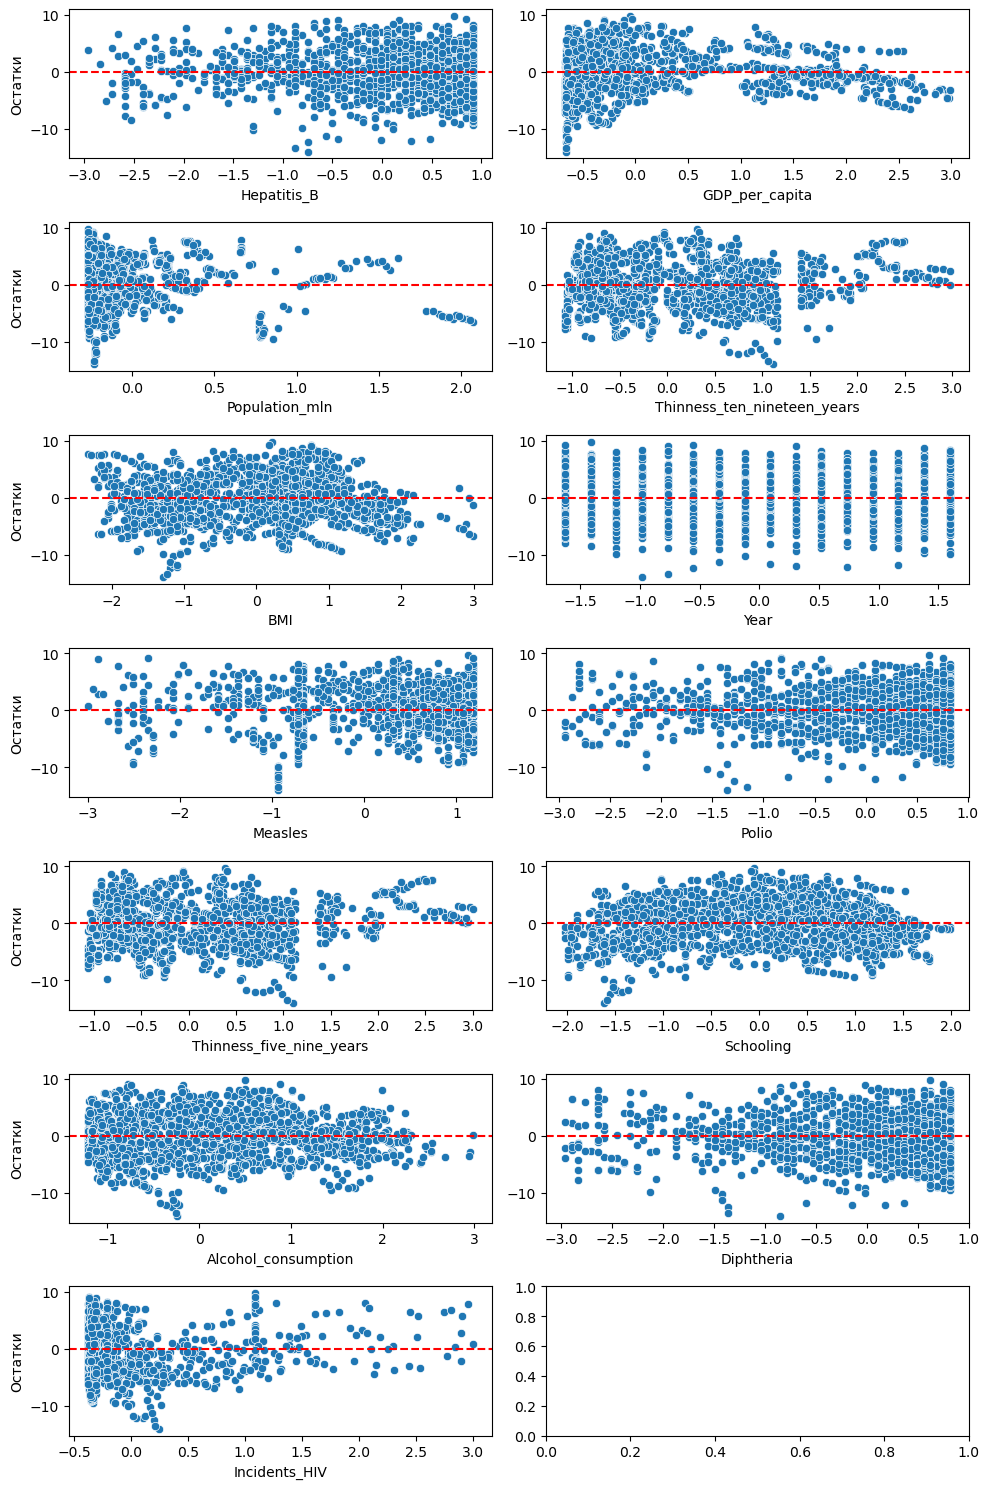

In [1010]:
fig, axes = plt.subplots(int(np.ceil(len(num_vars)/2)), 2, figsize=(10, 15))

for i, var in enumerate(X_train[list(num_vars)].columns):
    row = i // 2  
    col = i % 2  
    sns.scatterplot(x=X_train[var], y=model.resid, ax=axes[row, col])
    axes[row, col].axhline(y=0, color='red', linestyle='--')
    
    if col == 0:
        axes[row, col].set_ylabel('Остатки')

plt.tight_layout()

In [1011]:
X_train_log = X_train.copy()
X_test_log = X_test.copy()

scaler = StandardScaler()

# Список признаков для логарифмирования и стандартизации
features_to_log_transform = [
    'Population_mln', 
    'Incidents_HIV', 
    'GDP_per_capita', 
    'Thinness_ten_nineteen_years', 
    'Thinness_five_nine_years', 
    'Alcohol_consumption'
    ]

# Применяем логарифмирование к положительным признакам, добавляем 1 к минимальному значению
for feature in features_to_log_transform:
    if feature == 'Population_mlns':
        # Вычисляем сдвиг так, чтобы минимальное значение стало равным 1
        min_value_shift = X_train_log[feature].min()
        # Применяем логарифмирование
        X_train_log[feature] = np.log10(X_train_log[feature] - min_value_shift + 1)
        X_test_log[feature] = np.log10(X_test_log[feature] - min_value_shift + 1)
        # Применяем стандартизацию
        scaler.fit(X_train_log[[feature]])
        X_train_log[feature] = scaler.transform(X_train_log[[feature]])
        X_test_log[feature] = scaler.transform(X_test_log[[feature]])
    else:
        # Вычисляем сдвиг так, чтобы минимальное значение стало равным 1
        min_value_shift = X_train_log[feature].min()
        # Применяем логарифмирование
        X_train_log[feature] = np.log1p(X_train_log[feature] - min_value_shift)
        X_test_log[feature] = np.log1p(X_test_log[feature] - min_value_shift)
        # Применяем стандартизацию
        scaler.fit(X_train_log[[feature]])
        X_train_log[feature] = scaler.transform(X_train_log[[feature]])
        X_test_log[feature] = scaler.transform(X_test_log[[feature]])

X_train_log = X_train_log[np.abs(X_train_log) < 3].dropna()
y_train_log = y_train[X_train_log.index]

# Разделю на тестовую и тренировочную выборки

In [1012]:
model_classic = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred_train_classic = model_classic.fittedvalues
y_pred_test_classic = model_classic.predict(sm.add_constant(X_test))

model_classic_without_vifs = sm.OLS(y_train, sm.add_constant(X_train_without_vifs)).fit()
y_pred_train_classic_without_vifs = model_classic_without_vifs.fittedvalues
y_pred_test_classic_without_vifs = model_classic_without_vifs.predict(sm.add_constant(X_test_without_vifs))

model_classic_X_log = sm.OLS(y_train_log, sm.add_constant(X_train_log)).fit()
y_pred_train_classic_X_log = model_classic_X_log.fittedvalues
y_pred_test_classic_X_log = model_classic_X_log.predict(sm.add_constant(X_test_log))

model_classic_log = sm.OLS(np.log1p(y_train_log), sm.add_constant(X_train_log)).fit()
y_pred_train_classic_log = np.expm1(model_classic_log.fittedvalues)
y_pred_test_classic_log = np.expm1(model_classic_log.predict(sm.add_constant(X_test_log)))

# Создаем мультииндексные колонки
columns = pd.MultiIndex.from_tuples([
    ('Тренировочная выборка', 'R^2'),
    ('Тренировочная выборка', 'MAE'),
    ('Тренировочная выборка', 'MAPE'),
    ('Тестовая выборка', 'R^2'),
    ('Тестовая выборка', 'MAE'),
    ('Тестовая выборка', 'MAPE')
])

# Расчет метрик для классической модели
metrics_classic = calculate_metrics(
    y_train, y_pred_train_classic, y_test, y_pred_test_classic
)

# Расчет метрик для модели без мультиколлинеарности (без VIFs)
metrics_classic_without_vifs = calculate_metrics(
    y_train, y_pred_train_classic_without_vifs, y_test, y_pred_test_classic_without_vifs
)

metrics_classic_X_log = calculate_metrics(
    y_train_log, y_pred_train_classic_X_log, y_test, y_pred_test_classic_X_log
)

metrics_classic_log = calculate_metrics(
    y_train_log, y_pred_train_classic_log, y_test, y_pred_test_classic_log
)

results_df = pd.DataFrame(
    [metrics_classic, metrics_classic_without_vifs, metrics_classic_X_log, metrics_classic_log],
    index=['Классическая линейная регрессия', 'Линейная регрессия без вздутия дисперсий', 'Классическая линейная регрессия', 'Линейная регрессия с логарифмированной целевой переменной'],
    columns=columns
)

results_df['Логарифмированные признаки'] = [False, False, True, True]

cols = results_df.columns.tolist()
cols.remove(('Логарифмированные признаки', ''))
cols.insert(0, ('Логарифмированные признаки', ''))
results_df = results_df[cols]


results_df = results_df.reset_index()
results_df = results_df.set_index('Логарифмированные признаки', append=False)
results_df = results_df.set_index('index', append=True)
results_df.index.names = ['Логарифмированные признаки', 'Модель']


results_df

Тренировочная выборка  \
                                                                                                R^2   
Логарифмированные признаки Модель                                                                     
False                      Классическая линейная регрессия                                 0.819312   
                           Линейная регрессия без вздутия дисперсий                        0.818747   
True                       Классическая линейная регрессия                                 0.839845   
                           Линейная регрессия с логарифмированной целевой ...              0.827684   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     2.939832   
                           Линейная регрессия без вздутия дисперсий            2.947597   
True                       Классическая линейная регрессия                     2.637257   
                           Линейная регрессия с логарифмированной целевой ...  2.741216   

                                                                                         \
                                                                                   MAPE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     0.043742   
                           Линейная регрессия без вздутия дисперсий            0.043866   
True                       Классическая линейная регрессия                     0.038957   
                           Линейная регрессия с логарифмированной целевой ...  0.040266   

                                                                              Тестовая выборка  \
                                                                                           R^2   
Логарифмированные признаки Модель                                                                
False                      Классическая линейная регрессия                            0.781579   
                           Линейная регрессия без вздутия дисперсий                   0.779589   
True                       Классическая линейная регрессия                            0.838422   
                           Линейная регрессия с логарифмированной целевой ...         0.823960   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     3.313242   
                           Линейная регрессия без вздутия дисперсий            3.327975   
True                       Классическая линейная регрессия                     2.850090   
                           Линейная регрессия с логарифмированной целевой ...  2.986907   

                                                                                         
                                                                                   MAPE  
Логарифмированные признаки Модель                                                        
False                      Классическая линейная регрессия                     0.050301  
                           Линейная регрессия без вздутия дисперсий            0.050534  
True                       Классическая линейная регрессия                     0.042445  
                           Линейная регрессия с логарифмированной целевой ...  0.044250

In [1013]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):

    lasso = Lasso(
        alpha=trial.suggest_float("alpha", 0.0001, 50),
    )

    return np.mean(cross_val_score(lasso, X_train_log, y_train_log, scoring='r2', cv=5))

lasso_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
lasso_study.optimize(objective, timeout=5, show_progress_bar=True)

lasso_best_params = lasso_study.best_params



def objective(trial):

    ridge = Ridge(
        alpha=trial.suggest_float("alpha", 0.0001, 50),
    )

    return np.mean(cross_val_score(ridge, X_train_log, y_train_log, scoring='r2', cv=5))

ridge_study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
ridge_study.optimize(objective, timeout=5, show_progress_bar=True)

ridge_best_params = ridge_study.best_params

   0%|          | 00:00/00:05

   0%|          | 00:00/00:05

In [1014]:
print(f'''
Лучшие параметры Ridge: {ridge_best_params}
Лучшие параметры Lasso: {lasso_best_params}
''')


Лучшие параметры Ridge: {'alpha': 21.43214764138539}
Лучшие параметры Lasso: {'alpha': 0.02352372543187217}



In [1015]:
lasso = Lasso(**lasso_best_params).fit(X_train_log, y_train_log)
y_pred_train_lasso = lasso.predict(X_train_log)
y_pred_test_lasso = lasso.predict(X_test_log)

ridge = Ridge(**ridge_best_params).fit(X_train_log, y_train_log)
y_pred_train_ridge = ridge.predict(X_train_log)
y_pred_test_ridge = ridge.predict(X_test_log)


# Расчет метрик для модели Lasso регрессии
metrics_lasso = calculate_metrics(
    y_train_log, y_pred_train_lasso, y_test, y_pred_test_lasso
)

# Расчет метрик для модели Ridge регрессии
metrics_ridge = calculate_metrics(
    y_train_log, y_pred_train_ridge, y_test, y_pred_test_ridge
)

new_rows = pd.DataFrame(
    [metrics_lasso, metrics_ridge],
    index=[(True, 'Lasso регрессия'), (True, 'Ridge регрессия')],
    columns=columns
)

results_df = pd.concat([results_df, new_rows])

results_df

Тренировочная выборка  \
                                                                                                R^2   
Логарифмированные признаки Модель                                                                     
False                      Классическая линейная регрессия                                 0.819312   
                           Линейная регрессия без вздутия дисперсий                        0.818747   
True                       Классическая линейная регрессия                                 0.839845   
                           Линейная регрессия с логарифмированной целевой ...              0.827684   
                           Lasso регрессия                                                 0.839540   
                           Ridge регрессия                                                 0.839743   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     2.939832   
                           Линейная регрессия без вздутия дисперсий            2.947597   
True                       Классическая линейная регрессия                     2.637257   
                           Линейная регрессия с логарифмированной целевой ...  2.741216   
                           Lasso регрессия                                     2.636706   
                           Ridge регрессия                                     2.639216   

                                                                                         \
                                                                                   MAPE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     0.043742   
                           Линейная регрессия без вздутия дисперсий            0.043866   
True                       Классическая линейная регрессия                     0.038957   
                           Линейная регрессия с логарифмированной целевой ...  0.040266   
                           Lasso регрессия                                     0.038993   
                           Ridge регрессия                                     0.039012   

                                                                              Тестовая выборка  \
                                                                                           R^2   
Логарифмированные признаки Модель                                                                
False                      Классическая линейная регрессия                            0.781579   
                           Линейная регрессия без вздутия дисперсий                   0.779589   
True                       Классическая линейная регрессия                            0.838422   
                           Линейная регрессия с логарифмированной целевой ...         0.823960   
                           Lasso регрессия                                            0.840245   
                           Ridge регрессия                                            0.839420   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     3.313242   
                           Линейная регрессия без вздутия дисперсий            3.327975   
True                       Классическая линейная регрессия                     2.850090   
                           Линейная регрессия с логарифмированной целевой ...  2.

In [1016]:
train_poly = PolynomialFeatures(2, include_bias=False).fit(X_train_log)
test_poly = PolynomialFeatures(2, include_bias=False).fit(X_test_log)

X_log_train_poly = pd.DataFrame(
    train_poly.transform(X_train_log),
    index=X_train_log.index,
    columns=train_poly.get_feature_names_out()
)
X_log_test_poly = pd.DataFrame( 
    test_poly.transform(X_test_log),
    index=X_test_log.index,
    columns=test_poly.get_feature_names_out()
)

model_poly = sm.OLS(y_train_log, sm.add_constant(X_log_train_poly)).fit()
y_pred_train_model_poly = model_poly.fittedvalues
y_pred_test_model_poly = model_poly.predict(sm.add_constant(X_log_test_poly))

# Расчет метрик
metrics_poly = calculate_metrics(
    y_train_log, y_pred_train_model_poly, y_test, y_pred_test_model_poly
)

new_rows = pd.DataFrame(
    [metrics_poly],
    index=[(True, 'Регрессия с полиномиальными признаками')],
    columns=columns
)

results_df = pd.concat([results_df, new_rows])

results_df

Тренировочная выборка  \
                                                                                                R^2   
Логарифмированные признаки Модель                                                                     
False                      Классическая линейная регрессия                                 0.819312   
                           Линейная регрессия без вздутия дисперсий                        0.818747   
True                       Классическая линейная регрессия                                 0.839845   
                           Линейная регрессия с логарифмированной целевой ...              0.827684   
                           Lasso регрессия                                                 0.839540   
                           Ridge регрессия                                                 0.839743   
                           Регрессия с полиномиальными признаками                          0.943536   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     2.939832   
                           Линейная регрессия без вздутия дисперсий            2.947597   
True                       Классическая линейная регрессия                     2.637257   
                           Линейная регрессия с логарифмированной целевой ...  2.741216   
                           Lasso регрессия                                     2.636706   
                           Ridge регрессия                                     2.639216   
                           Регрессия с полиномиальными признаками              1.494157   

                                                                                         \
                                                                                   MAPE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     0.043742   
                           Линейная регрессия без вздутия дисперсий            0.043866   
True                       Классическая линейная регрессия                     0.038957   
                           Линейная регрессия с логарифмированной целевой ...  0.040266   
                           Lasso регрессия                                     0.038993   
                           Ridge регрессия                                     0.039012   
                           Регрессия с полиномиальными признаками              0.022257   

                                                                              Тестовая выборка  \
                                                                                           R^2   
Логарифмированные признаки Модель                                                                
False                      Классическая линейная регрессия                            0.781579   
                           Линейная регрессия без вздутия дисперсий                   0.779589   
True                       Классическая линейная регрессия                            0.838422   
                           Линейная регрессия с логарифмированной целевой ...         0.823960   
                           Lasso регрессия                                            0.840245   
                           Ridge регрессия                                            0.839420   
                           Регрессия с полиномиальными признаками                     0.225180   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                             

In [1017]:
print(model_classic_X_log.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     614.5
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:52:07   Log-Likelihood:                -4956.8
No. Observations:                1892   AIC:                             9948.
Df Residuals:                    1875   BIC:                         1.004e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

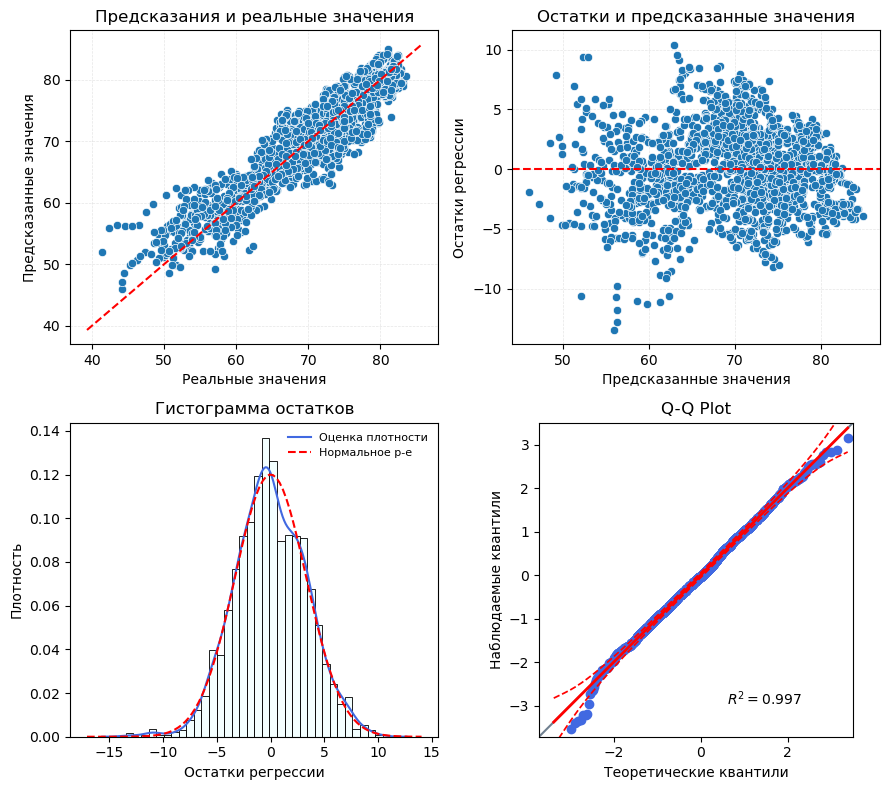

In [1018]:
get_visual_residual_analysis(model_classic_X_log.fittedvalues, model_classic_X_log.model.endog)

In [1019]:
get_residual_analysis(model_classic_X_log.resid, model_classic_X_log.model.exog, 0.05) 

,p-values,Отклоняем H0,Вывод
Тест Шапиро-Уилка,4.371686e-03,True,Остатки не распределены нормально
Тест Бреуша-Пагана,5.932794e-33,True,Присутствует гетероскедастичность
Тест Уайта,4.433634e-87,True,Присутствует гетероскедастичность


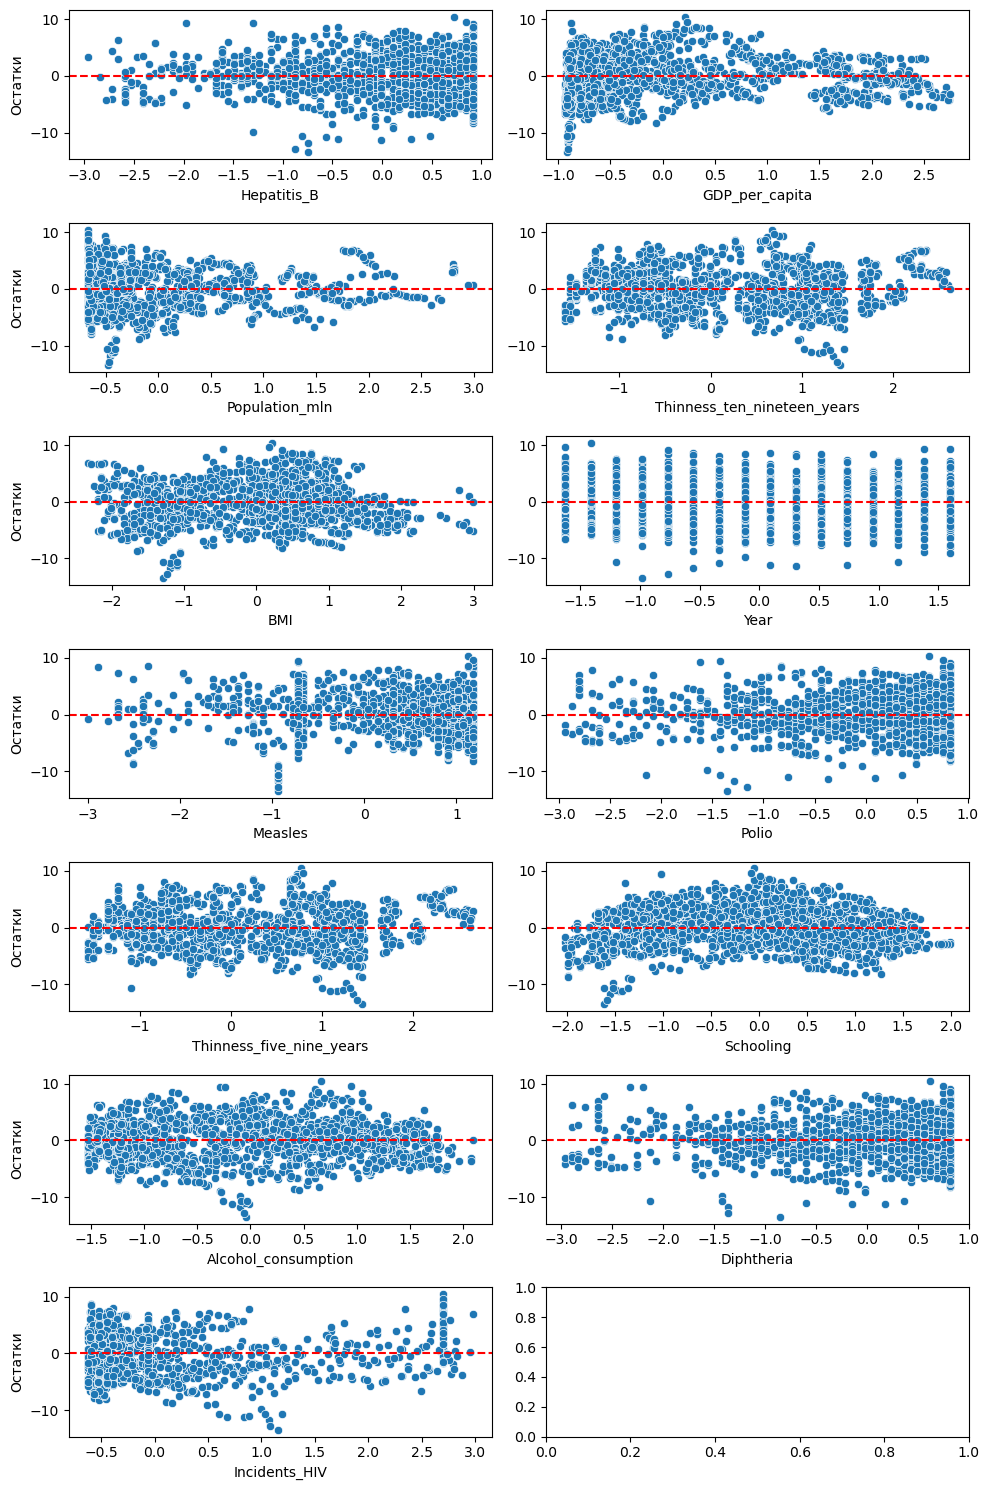

In [1020]:
fig, axes = plt.subplots(int(np.ceil(len(num_vars)/2)), 2, figsize=(10, 15))

for i, var in enumerate(X_train_log[list(num_vars)].columns):
    row = i // 2  
    col = i % 2  
    sns.scatterplot(x=X_train_log[var], y=model_classic_X_log.resid, ax=axes[row, col])
    axes[row, col].axhline(y=0, color='red', linestyle='--')
    
    if col == 0:
        axes[row, col].set_ylabel('Остатки')

plt.tight_layout()

In [1021]:
robust_white = model_classic_X_log.get_robustcov_results(cov_type='HC1')
print(robust_white.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     718.9
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:52:11   Log-Likelihood:                -4956.8
No. Observations:                1892   AIC:                             9948.
Df Residuals:                    1875   BIC:                         1.004e+04
Df Model:                          16                                         
Covariance Type:                  HC1                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [1022]:
p_values_robust_white = pd.Series(robust_white.pvalues, index=robust_white.model.exog_names)

In [1023]:
important_features = p_values_robust_white[p_values_robust_white < 0.05].drop('const').index

In [1024]:
X_train_log = X_train_log[important_features]
X_test_log = X_test_log[important_features]

model_classic_X_log = sm.OLS(y_train_log, sm.add_constant(X_train_log)).fit()
robust_white = model_classic_X_log.get_robustcov_results(cov_type='HC1')
print(robust_white.summary())

                            OLS Regression Results                            
Dep. Variable:        Life_expectancy   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1022.
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:52:11   Log-Likelihood:                -4961.3
No. Observations:                1892   AIC:                             9947.
Df Residuals:                    1880   BIC:                         1.001e+04
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  69.4189    

In [1025]:
y_pred_train_robust_white = robust_white.predict(sm.add_constant(X_train_log))
y_pred_test_robust_white = robust_white.predict(sm.add_constant(X_test_log))

metrics_important = calculate_metrics(
    y_train_log, y_pred_train_robust_white, y_test, y_pred_test_robust_white
)

new_rows = pd.DataFrame(
    [metrics_important],
    index=[(True, 'Регрессия с удалёнными незначимыми признаками')],
    columns=columns
)

results_df = pd.concat([results_df, new_rows])

results_df

Тренировочная выборка  \
                                                                                                R^2   
Логарифмированные признаки Модель                                                                     
False                      Классическая линейная регрессия                                 0.819312   
                           Линейная регрессия без вздутия дисперсий                        0.818747   
True                       Классическая линейная регрессия                                 0.839845   
                           Линейная регрессия с логарифмированной целевой ...              0.827684   
                           Lasso регрессия                                                 0.839540   
                           Ridge регрессия                                                 0.839743   
                           Регрессия с полиномиальными признаками                          0.943536   
                           Регрессия с удалёнными незначимыми признаками                   0.839096   

                                                                                         \
                                                                                    MAE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     2.939832   
                           Линейная регрессия без вздутия дисперсий            2.947597   
True                       Классическая линейная регрессия                     2.637257   
                           Линейная регрессия с логарифмированной целевой ...  2.741216   
                           Lasso регрессия                                     2.636706   
                           Ridge регрессия                                     2.639216   
                           Регрессия с полиномиальными признаками              1.494157   
                           Регрессия с удалёнными незначимыми признаками       2.632568   

                                                                                         \
                                                                                   MAPE   
Логарифмированные признаки Модель                                                         
False                      Классическая линейная регрессия                     0.043742   
                           Линейная регрессия без вздутия дисперсий            0.043866   
True                       Классическая линейная регрессия                     0.038957   
                           Линейная регрессия с логарифмированной целевой ...  0.040266   
                           Lasso регрессия                                     0.038993   
                           Ridge регрессия                                     0.039012   
                           Регрессия с полиномиальными признаками              0.022257   
                           Регрессия с удалёнными незначимыми признаками       0.038932   

                                                                              Тестовая выборка  \
                                                                                           R^2   
Логарифмированные признаки Модель                                                                
False                      Классическая линейная регрессия                            0.781579   
                           Линейная регрессия без вздутия дисперсий                   0.779589   
True                       Классическая линейная регрессия                            0.838422   
                           Линейная регрессия с логарифмированной целевой ...         0.823960   
                           Lasso регрессия                                            0.840245   
                           Ridge регрессия                                            0.839420   
                           Регрессия с полиномиальными при

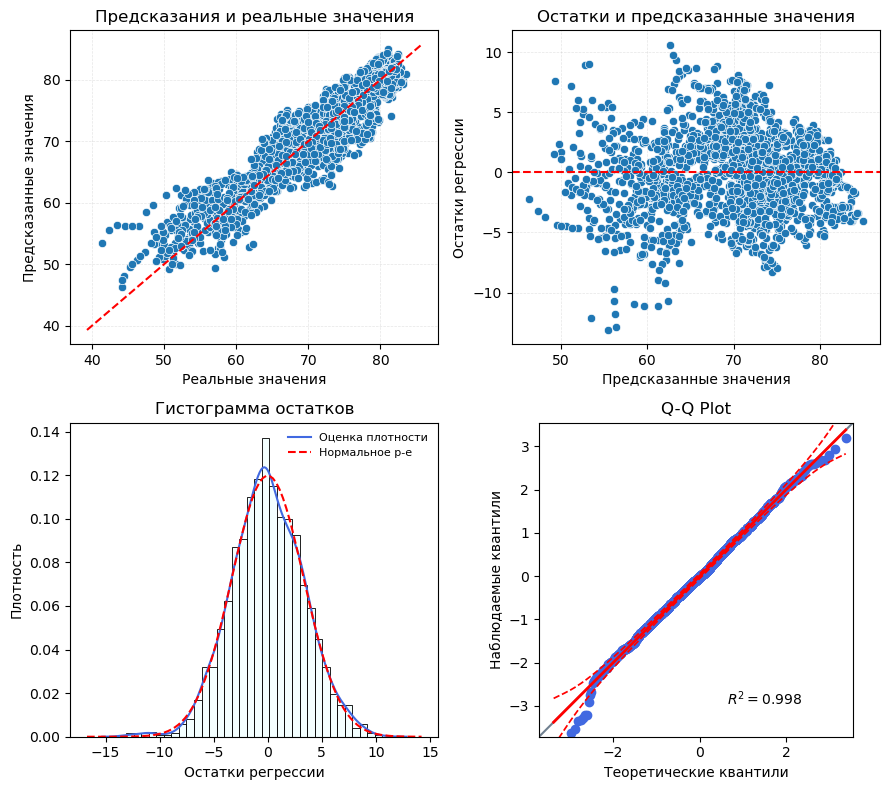

In [1026]:
get_visual_residual_analysis(robust_white.fittedvalues, robust_white.model.endog)

In [1027]:
get_residual_analysis(robust_white.resid, robust_white.model.exog, 0.05)

,p-values,Отклоняем H0,Вывод
Тест Шапиро-Уилка,6.183770e-03,True,Остатки не распределены нормально
Тест Бреуша-Пагана,4.895990e-26,True,Присутствует гетероскедастичность
Тест Уайта,2.641100e-79,True,Присутствует гетероскедастичность


In [1028]:
equation = pd.Series(robust_white.params, index=robust_white.model.exog_names).sort_values(ascending=False, key=lambda x: np.abs(x))
equation

const                  69.418945
Incidents_HIV          -2.949200
GDP_per_capita          2.768036
Polio                   2.243585
BMI                     1.139865
Schooling               1.112121
Population_mln          0.900879
Region                  0.645138
Alcohol_consumption     0.427293
Year                    0.402578
Measles                 0.378723
Country                 0.178792
dtype: float64

In [1029]:
equation = np.abs(equation[1:])

feature_importances = (equation / np.sum(equation)) * 100

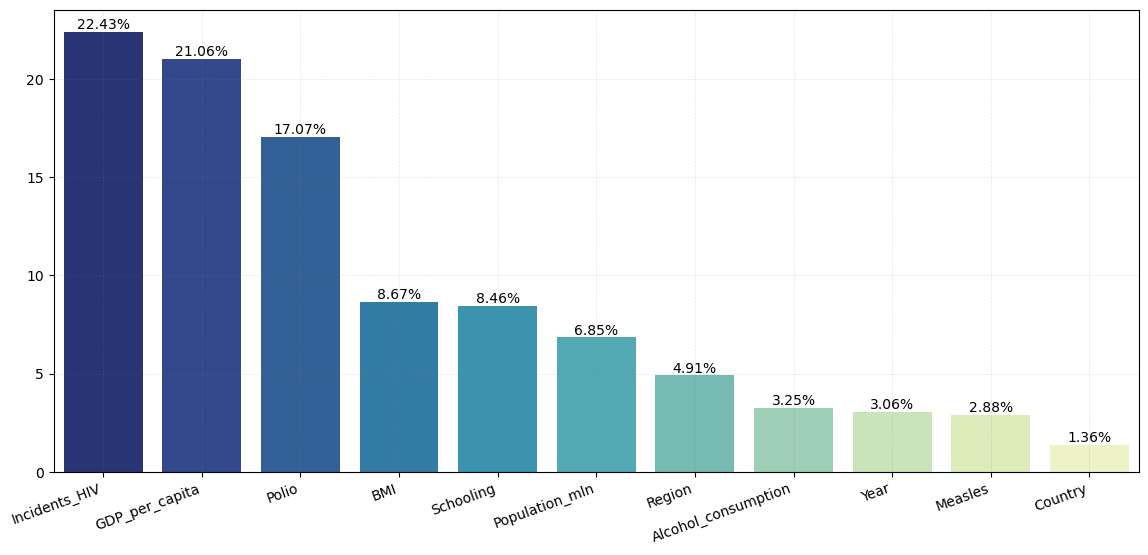

In [1030]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    x=feature_importances.index, 
    y=feature_importances, 
    palette="YlGnBu_r",

)
ax.bar_label(ax.containers[0], fontsize=10, fmt='%.2f%%')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.2)